In [29]:
# !pip install deap
# !pip install bitstring
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/drive/MyDrive/neuroapprox/elitism.py /content

In [30]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp

from keras import activations
from keras.losses import CategoricalCrossentropy
from keras.models import Model

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

from elitism import eaSimpleWithElitism, main

In [31]:
np.random.seed(0)

tf.config.optimizer.set_jit(True)
scaler = StandardScaler()

### Conjunto de datos: SDSS DR17

In [32]:
url = "https://raw.githubusercontent.com/igomezv/neurapprox/main/SDSS/star_classification.csv"
data = pd.read_csv(url)
cols = ['alpha','delta','u','g','r','i','z','redshift','class']
data = data[cols]
data.head()

,alpha,delta,u,g,r,i,z,redshift,class
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY


Se cambian las clases a vectores con números enteros

$$ \text{GALAXY}: \begin{pmatrix}1\\0\\0\end{pmatrix},\quad \text{STAR}: \begin{pmatrix}0\\1\\0\end{pmatrix},\quad \text{QSO}:\begin{pmatrix}0\\0\\1\end{pmatrix} $$

In [33]:
data["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in data["class"]]
print(data.head())
data = data.to_numpy()

        alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   
3  338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454  19.25010   
4  345.282593  21.183866  19.43718  17.58028  16.49747  15.97711  15.54461   

   redshift  class  
0  0.634794      0  
1  0.779136      0  
2  0.644195      0  
3  0.932346      0  
4  0.116123      0  


### Implementación

Se establecen las funciones necesarias para aplicar el algorítmo genético a partir de lo siguiente

- 1) Decodificar el gen del individuo para obtener el núm. de capas ocultas, núm. de neuronas, la tasa de aprendizaje, etc.
    
    
- 2) Preparar el conjunto de datos para dividirlos en conjunto de entrenamiento, validación y prueba.
    
    
- 3) Entrenar la red neuronal, calcular el error del modelo en el conjunto de validación y regresarlo como fitness para el algorítmo genético.

In [34]:
# Activation function layers

f1 = lambda x: Dense(x, activation='relu')      #ReLU
f2 = lambda x: Dense(x, activation='elu')       #ELU
f3 = lambda x: keras.layers.LeakyReLU(0.3)      #LReLU
f4 = lambda x: Dense(x, kernel_initializer='lecun_normal', activation='selu')   #SELU

f_names = ["ReLU", "ELU", "LReLU", "SELU"]

In [55]:
SC_DEEP       = np.array([2,3,4,5,6,7,8,9])                           # Number of deep layers (8)
SC_NUM_UNITS  = np.array([2,3,4,5,6,8,10,13,16,21,26,31,42,55,68,89]) # Number of fully conected neurons (16)
SC_LEARNING   = np.array([5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1])   # Learning rates (8)
SC_BATCH      = np.array([64,128,256,512])                            # Batch sizes (4)
SC_ACTIVATION = [f1, f2, f3, f4]                                      # Activation function layers (2)

my_callbacks = [keras.callbacks.EarlyStopping(
                               monitor='val_loss', mode='min',
                               min_delta=0, 
                               patience=9,
                               verbose=1,
                            #    baseline=0,
                               restore_best_weights=1),
#                 keras.callbacks.TensorBoard(
#                                log_dir='./logs'),
                keras.callbacks.ReduceLROnPlateau(
                               monitor='val_loss', factor=0.5,
                               patience=6, min_lr=0,
                               verbose=1)] 
    
epochs = 175
# epochs = 3

In [56]:
# Divide data into X and Y and implement hot_ones in Y
def prepare_dataset(data):
    X, Y = np.empty((0)), np.empty((0))
    X = data[:,0:8]
    Y = data[:,8]
    Y = to_categorical(Y, num_classes=3)
    return X, Y

In [57]:
# Split dataset into train, validation and test sets
X,Y = prepare_dataset(data)

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
x_, X_test, y_, Y_test = split(X, Y, test_size = ratio_test, random_state=0)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X_train, X_val, Y_train, Y_val = split(x_, y_, test_size=ratio_val_adjusted, random_state=0)

# Normalize and scale the input sets.
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_val   = scaler.transform(X_val)

### Arquitectura del modelo

In [58]:
def train_evaluate(ga_individual_solution):   
    t = time.time(); t_total = 0
    
    # Decode GA solution to integer for window_size and num_units
    deep_layers_bits   = BitArray(ga_individual_solution[0:3])     # (8)
    num_units_bits     = BitArray(ga_individual_solution[3:7])     # (16)
    learning_rate_bits = BitArray(ga_individual_solution[7:10])    # (8)
    batch_size_bits    = BitArray(ga_individual_solution[10:12])   # (4)
    activation_f_bits  = BitArray(ga_individual_solution[12:13])   # (2)   Solo se consideran las 2 primeras
    
    deep_layers   = SC_DEEP[deep_layers_bits.uint]
    num_units     = SC_NUM_UNITS[num_units_bits.uint]
    learning_rate = SC_LEARNING[learning_rate_bits.uint]
    batch_size   = SC_BATCH[batch_size_bits.uint]
    activation_f  = SC_ACTIVATION[activation_f_bits.uint]
    
    print('\n--------------- Starting trial:', population_size*(max_generations+1)-len(ss), "---------------")
    print('Deep layers:',deep_layers,', Number of neurons:',num_units,", Learning rate:",learning_rate, ", Batch size:", batch_size, ', Activation function:',f_names[activation_f_bits.uint])
#     print("-------------------------------------------------")
    
    # Train model and predict on validation set
    model = keras.Sequential()
    model.add(Input(shape=(int(X_train.shape[1]),)))
    model.add(Dense(num_units, input_shape=(int(X_train.shape[1]),)))
    
    for i in range(deep_layers):        
        model.add(activation_f(num_units))
#         if i % SC_NUM_UNITS[3]==0:
#             model.add(keras.layers.Dropout(0.3))
    model.add(Dense(3, activation=tf.nn.softmax))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
              callbacks=my_callbacks, batch_size=batch_size, shuffle=1, verbose=0)
    
    loss, score = model.evaluate(X_val, Y_val)    
    t = time.time()-t; ss.pop(0)
    print("Accuracy:", score, ", Elapsed time:", t)
    print("-------------------------------------------------\n")
#     print(loss, score)

    datos.append([deep_layers, num_units, learning_rate, batch_size, f_names[activation_f_bits.uint], loss, score, t])
    
    return loss,

A continuación, use la paquetería DEAP para definir las cosas para ejecutar GA. Usaremos una representación binaria para la solución de longitud diez. Se inicializará aleatoriamente utilizando la distribución de Bernoulli. Del mismo modo, se utiliza el crossover ordenado, la mutación aleatoria y la selección de la rueda de la ruleta. Los valores del parámetro GA se inicializan arbitrariamente.

In [59]:
from deap import tools
from deap import algorithms

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [60]:
def geneticAlgorithm_with_elitism(population_size, max_generations, gene_length, k):
    
    # Genetic Algorithm constants:
    P_CROSSOVER = 0.9        # probability for crossover
    P_MUTATION = 0.3         # probability for mutating an individual
    HALL_OF_FAME_SIZE = 1    # Best individuals that pass to the other generation
    
    # set the random seed:
    toolbox = base.Toolbox()

    # As we are trying to minimize the RMSE score, that's why using -1.0. 
    # In case, when you want to maximize accuracy for instance, use 1.0
    creator.create('FitnessMin', base.Fitness, weights = [-1.0])
    creator.create('Individual', list , fitness = creator.FitnessMin)

    # create the individual operator to fill up an Individual instance:
    toolbox.register('binary', bernoulli.rvs, 0.5)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)

    # create the population operator to generate a list of individuals:
    toolbox.register('population', tools.initRepeat, list , toolbox.individual)

    # genetic operators:
    toolbox.register('evaluate', train_evaluate)
    toolbox.register('select', tools.selTournament, tournsize = 2)
    toolbox.register('mutate', tools.mutFlipBit, indpb = 0.11)
    toolbox.register('mate', tools.cxUniform, indpb = 0.5)
    
    # create initial population (generation 0):
    population = toolbox.population(n=population_size)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # Genetic Algorithm flow with elitism:
    population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=max_generations, stats=stats, halloffame=hof, verbose=True)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    # extract statistics:
    minFitnessValues, meanFitnessValues, maxFitnessValues = logbook.select("min", "max", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='blue', label="Min")
    plt.plot(meanFitnessValues, color='green', label="Mean")
    plt.plot(maxFitnessValues, color='red', label="Max")
    plt.xlabel('Generation'); plt.ylabel('Max / Min / Average Fitness')
    plt.legend()
    plt.title('Max, Min and Average fitness over Generations')
    plt.show()
    
    best_population = tools.selBest(population,k = k)
    return best_population

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



--------------- Starting trial: 1 ---------------
Deep layers: 5 , Number of neurons: 55 , Learning rate: 0.05 , Batch size: 256 , Activation function: ReLU

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.025.
Restoring model weights from the end of the best epoch: 4.
Epoch 13: early stopping
313/313 [==============================] - 0s 2ms/step - loss: 0.1232 - accuracy: 0.9638
Accuracy: 0.9638000130653381 , Elapsed time: 15.91141676902771
-------------------------------------------------


--------------- Starting trial: 2 ---------------
Deep layers: 8 , Number of neurons: 5 , Learning rate: 0.01 , Batch size: 512 , Activation function: ELU

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.005.
Restoring model weights from the end of the best epoch: 21.
Epoch 30: early stopping
313/313 [==============================] - 1s 2ms/step - loss: 0.1020 - accuracy: 0.9694
Accuracy: 0.9693999886512756 , Elapsed time: 22.006415843963623
-------------------------------------

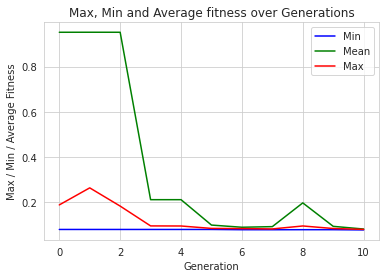

Total elapsed time: 147.6308643301328 minutes


In [61]:
population_size = 10   # max of individuals per generation
max_generations = 10   # number of generations
gene_length = 13       # lenght of the gene, depends on how many hiperparameters are tested  
k = 5;                 # num. of finalist individuals

if __name__ == "__main__":
    t = time.time(); 
    datos = [];
    ss = [i for i in range(1,population_size*(max_generations+1))]
    best_population = geneticAlgorithm_with_elitism(population_size, max_generations, gene_length, k)
    print("Total elapsed time:", (time.time()-t)/60, "minutes")

### Guardar datos

In [62]:
best_deep_layers   = []
best_num_units     = []
best_learning_rate = []
best_batch_size    = []
best_activation_f  = []
best_f_names       = []

t = 0

for bi in best_population:
    deep_layers_bits   = BitArray(bi[0:3])    # (8)
    num_units_bits     = BitArray(bi[3:7])    # (16)
    learning_rate_bits = BitArray(bi[7:10])   # (8)
    batch_size_bits    = BitArray(bi[10:12])  # (4)
    activation_f_bits  = BitArray(bi[12:13])  # (2)
    t += 1 
    
    best_deep_layers.append(SC_DEEP[deep_layers_bits.uint])
    best_num_units.append(SC_NUM_UNITS[num_units_bits.uint])
    best_learning_rate.append(SC_LEARNING[learning_rate_bits.uint])
    best_batch_size.append(SC_BATCH[batch_size_bits.uint])
    best_activation_f.append(SC_ACTIVATION[activation_f_bits.uint])
    best_f_names.append(f_names[activation_f_bits.uint])
    
    print('k=',t,'\nDeep layers:', best_deep_layers[-1], ', Number of neurons:', best_num_units[-1], ', Learning rate:', best_learning_rate[-1], ", Batch size:", best_batch_size[-1], ", Activation function: ", best_f_names[-1])

k= 1 
Deep layers: 8 , Number of neurons: 21 , Learning rate: 0.005 , Batch size: 64 , Activation function:  ELU
k= 2 
Deep layers: 8 , Number of neurons: 21 , Learning rate: 0.005 , Batch size: 256 , Activation function:  ELU
k= 3 
Deep layers: 8 , Number of neurons: 21 , Learning rate: 0.005 , Batch size: 256 , Activation function:  ELU
k= 4 
Deep layers: 8 , Number of neurons: 21 , Learning rate: 0.005 , Batch size: 256 , Activation function:  ELU
k= 5 
Deep layers: 8 , Number of neurons: 21 , Learning rate: 0.005 , Batch size: 64 , Activation function:  ELU


In [63]:
filename = "historial_sdss.txt"
df = pd.DataFrame(datos, columns = ["Deep layers", "Num units", "Learning rate", "Batch size",
                                    "Activation function", "Loss", "Accuracy", "Elapsed time"])

df.sort_values(by=["Accuracy", "Elapsed time"], ascending=[0,1], ignore_index=True, inplace=True)

df.to_csv(filename, header=True, index=False, sep='\t', mode='w') # a=append, w=overwrite

df

,Deep layers,Num units,Learning rate,Batch size,Activation function,Loss,Accuracy,Elapsed time
0,8,21,0.005,256,ELU,0.078420,0.9766,89.436062
1,8,21,0.005,64,ELU,0.076465,0.9765,287.389786
2,8,21,0.005,256,ELU,0.077373,0.9762,95.074142
3,8,21,0.005,256,ELU,0.077479,0.9762,143.346319
4,8,21,0.005,256,ELU,0.078497,0.9761,125.940679
...,...,...,...,...,...,...,...,...
81,4,55,0.050,256,ELU,0.196220,0.9260,11.699162
82,4,2,0.005,256,ReLU,0.952404,0.5966,10.429308
83,9,42,0.100,256,ReLU,0.952378,0.5966,30.415109
84,9,16,0.100,128,ELU,0.952502,0.5966,42.467000


In [64]:
np.sum(df[["Elapsed time"]])/60/60

Elapsed time    2.460368
dtype: float64

### Cargar datos

In [65]:
pathname = os.path.join('.\\', filename)
while True:
    try: 
        df 
        break
    except:
        df = pd.read_csv(pathname, delimiter = "\t")
        break
        
df

,Deep layers,Num units,Learning rate,Batch size,Activation function,Loss,Accuracy,Elapsed time
0,8,21,0.005,256,ELU,0.078420,0.9766,89.436062
1,8,21,0.005,64,ELU,0.076465,0.9765,287.389786
2,8,21,0.005,256,ELU,0.077373,0.9762,95.074142
3,8,21,0.005,256,ELU,0.077479,0.9762,143.346319
4,8,21,0.005,256,ELU,0.078497,0.9761,125.940679
...,...,...,...,...,...,...,...,...
81,4,55,0.050,256,ELU,0.196220,0.9260,11.699162
82,4,2,0.005,256,ReLU,0.952404,0.5966,10.429308
83,9,42,0.100,256,ReLU,0.952378,0.5966,30.415109
84,9,16,0.100,128,ELU,0.952502,0.5966,42.467000


### Entrenamiento con los mejores individuos

In [66]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set

models = []
historial = []
Y_pred = []

for k in range(len(best_deep_layers)):
    print('\n--------------- Starting trial:', k+1, "---------------")
    print('Deep Layers:',best_deep_layers[k],', Number of neurons:',best_num_units[k],', Learning rate:',best_learning_rate[k], ", Batch size:", best_batch_size[k], ', Activation function:',best_f_names[k])
    
    
#     Train model and predict on test set
    models.append(keras.Sequential())
    models[-1].add(Input(shape=(int(X_train.shape[1]),)))
    models[-1].add(Dense(best_num_units[k], input_shape=(int(X_train.shape[1]),)))

    for i in range(best_deep_layers[k]):        
        models[-1].add(best_activation_f[k](best_num_units[k]))
    models[-1].add(Dense(3, activation=tf.nn.softmax))

    optimizer = keras.optimizers.Adam(learning_rate=best_learning_rate[k], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    models[-1].compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=["categorical_accuracy"])
            
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                       min_delta=0.00001,
                                       patience=13,
                                       restore_best_weights=True),
                 keras.callbacks.ReduceLROnPlateau(
                               monitor='val_loss', factor=0.5,
                               patience=8, min_lr=0.000001,
                               verbose=1)]
    
    historial.append(models[-1].fit(X_train, Y_train, epochs=epochs*2, validation_data=(X_val, Y_val),
                                    batch_size=best_batch_size[k], callbacks=callbacks, shuffle=True, verbose=0))
    Y_pred.append(models[-1].predict(X))
    
    loss, score = models[-1].evaluate(X_test, Y_test)
    print("Accuracy:", score)
    print("-------------------------------------------------\n")


--------------- Starting trial: 1 ---------------
Deep Layers: 8 , Number of neurons: 21 , Learning rate: 0.005 , Batch size: 64 , Activation function: ELU

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0025.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.00125.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.000625.

Epoch 92: ReduceLROnPlateau reducing learning rate to 0.0003125.

Epoch 103: ReduceLROnPlateau reducing learning rate to 0.00015625.

Epoch 111: ReduceLROnPlateau reducing learning rate to 7.8125e-05.
313/313 [==============================] - 1s 2ms/step - loss: 0.0863 - categorical_accuracy: 0.9740
Accuracy: 0.9739999771118164
-------------------------------------------------


--------------- Starting trial: 2 ---------------
Deep Layers: 8 , Number of neurons: 21 , Learning rate: 0.005 , Batch size: 256 , Activation function: ELU

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0025.

Epoch 90: ReduceLROnPlateau reducing learning 

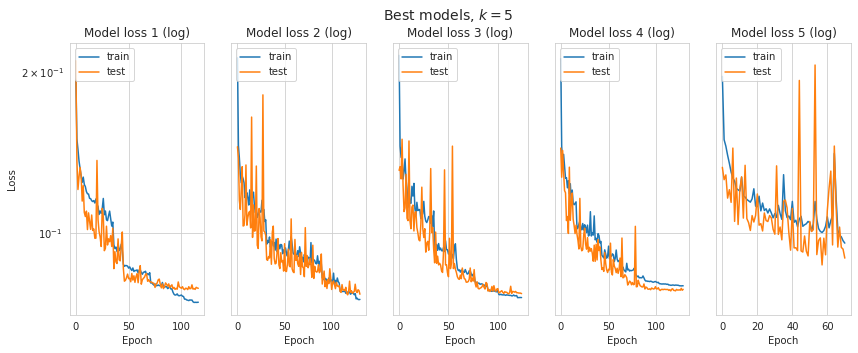

In [67]:
fig, axs = plt.subplots(1, 5, figsize=(14,5), sharey='row')
fig.suptitle(r'Best models, $k=5$', fontsize=14)
titles = []
for k in range(len(models)):
    titles.append(f"Model loss {k+1} (log)")
    axs[k].plot(historial[k].history['loss'])
    axs[k].plot(historial[k].history['val_loss'])
    axs[k].set_title(titles[-1])
    axs[k].set_yscale("log")
    axs[k].legend(['train', 'test'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')
axs.flat[0].set(ylabel='Loss')
plt.show()

### Gráficas de comparación

In [117]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(Y_test, Y_pred, labels, porcentaje=False, cbar=False, ax=None):
    #Generamos la matriz de confusión a partir de los dos arreglos
    matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred)
    
    #Aquí se divide si queremos en porcentaje o números
    if porcentaje==False: ax = sns.heatmap(matrix, annot=True, cmap="OrRd", cbar=cbar, cbar_kws={'label': 'scale'}, ax=ax)
    if porcentaje==True:
        m=np.zeros(matrix.shape)
        for j in range(0,matrix.shape[1]):
            m[:,j]=matrix[:,j]/np.sum(matrix[:,j])
        ax = sns.heatmap(m, annot=True,fmt='.2%', cmap='OrRd', cbar=cbar, cbar_kws={'label': 'scale'}, ax=ax)
 
    # ax.set_xticklabels(labels)
    # ax.set_yticklabels(labels)
 
    # ax.set(xlabel="True label", ylabel="Predicted label")

    return ax

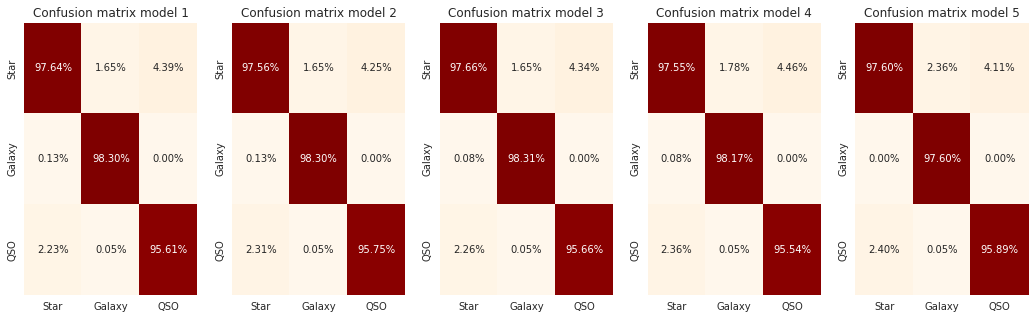

In [125]:
X_test_inverse = scaler.inverse_transform(X_test)
Y_pred = []
labels=['Star','Galaxy','QSO']
porcentaje = True

fig, axs = plt.subplots(1, 5, figsize=(18,5), gridspec_kw={'width_ratios':[1,1,1,1,1]})
titles = []
for i in range(len(models)):
    titles.append(f"Confusion matrix model {i+1}")
    Y_pred.append(np.argmax(models[i].predict(X_test), axis=1))
    plot_cm(Y_test, Y_pred[i], labels, porcentaje=porcentaje, ax=axs[i])
    axs[i].set_title(titles[-1])
    axs[i].set_xticklabels(labels); axs[i].set_yticklabels(labels)

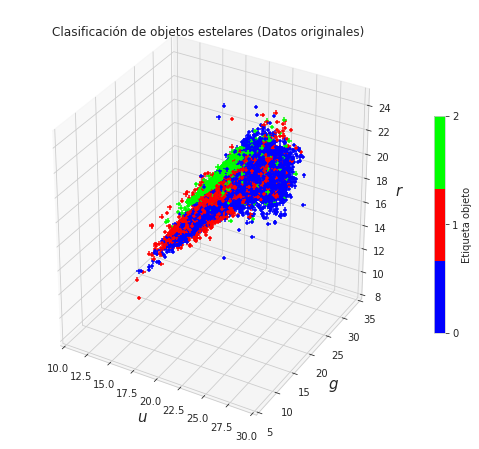

In [119]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
cmap = mpl.cm.get_cmap("brg", 3)

p = ax.scatter(X_test_inversed[:,2], X_test_inversed[:,3], X_test_inversed[:,4], marker='+', c=np.argmax(Y_test, axis=1), cmap=cmap, alpha=1)
ax.set_xlabel('$u$', fontsize=15); ax.set_xlim([10, 30])
ax.set_ylabel('$g$', fontsize=15); ax.set_ylim([5, 35])
ax.set_zlabel('$r$', fontsize=15); ax.set_zlim([8, 25])

plt.colorbar(p, shrink=0.5, label='Etiqueta objeto', ticks=np.array([0,1,2]));
plt.title(r"Clasificación de objetos estelares (Datos originales)")
plt.show()

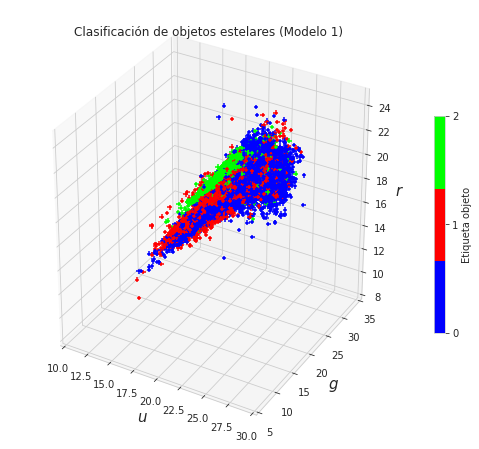

In [120]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
cmap = mpl.cm.get_cmap("brg", 3)

p = ax.scatter(X_test_inversed[:,2], X_test_inversed[:,3], X_test_inversed[:,4], marker='+', c=Y_pred[0], cmap=cmap, alpha=1)
ax.set_xlabel('$u$', fontsize=15); ax.set_xlim([10, 30])
ax.set_ylabel('$g$', fontsize=15); ax.set_ylim([5, 35])
ax.set_zlabel('$r$', fontsize=15); ax.set_zlim([8, 25])

plt.colorbar(p, shrink=0.5, label='Etiqueta objeto', ticks=np.array([0,1,2]));
plt.title(r"Clasificación de objetos estelares (Modelo 1)")
plt.show()

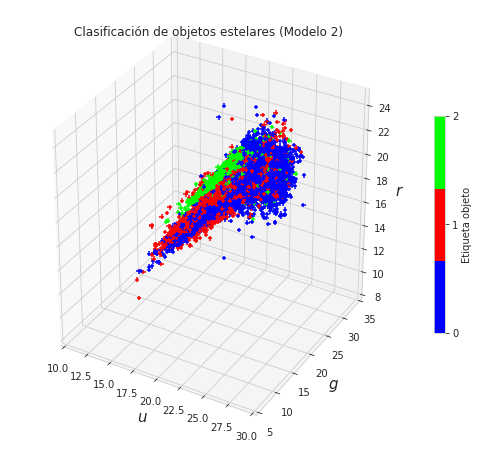

In [121]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
cmap = mpl.cm.get_cmap("brg", 3)

p = ax.scatter(X_test_inversed[:,2], X_test_inversed[:,3], X_test_inversed[:,4], marker='+', c=Y_pred[2], cmap=cmap, alpha=1)
ax.set_xlabel('$u$', fontsize=15); ax.set_xlim([10, 30])
ax.set_ylabel('$g$', fontsize=15); ax.set_ylim([5, 35])
ax.set_zlabel('$r$', fontsize=15); ax.set_zlim([8, 25])

plt.colorbar(p, shrink=0.5, label='Etiqueta objeto', ticks=np.array([0,1,2]));
plt.title(r"Clasificación de objetos estelares (Modelo 2)")
plt.show()

### Resultado de hiperparámetros

In [122]:
df.head()

,Deep layers,Num units,Learning rate,Batch size,Activation function,Loss,Accuracy,Elapsed time
0,8,21,0.005,256,ELU,0.078420,0.9766,89.436062
1,8,21,0.005,64,ELU,0.076465,0.9765,287.389786
2,8,21,0.005,256,ELU,0.077373,0.9762,95.074142
3,8,21,0.005,256,ELU,0.077479,0.9762,143.346319
4,8,21,0.005,256,ELU,0.078497,0.9761,125.940679


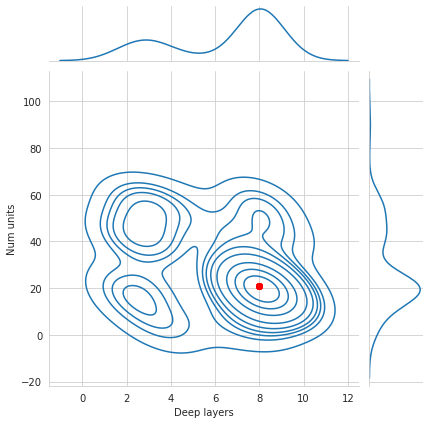

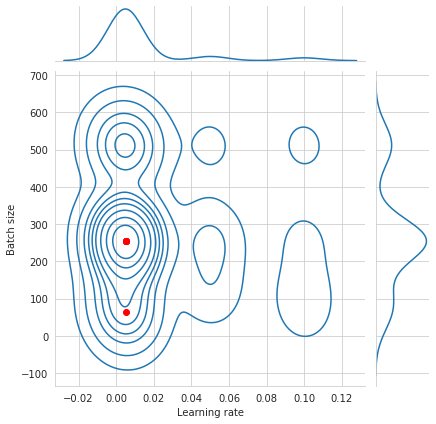

In [123]:
g1= sns.jointplot(data=df, x="Deep layers", y="Num units", kind="kde")
g1.ax_joint.scatter(df.iloc[0:5,0], df.iloc[0:5,1], color = 'red', label="a")

plt.show()

g2= sns.jointplot(x=df.iloc[:,2], y=df.iloc[:,3], kind='kde')
g2.ax_joint.scatter(df.iloc[0:5,2], df.iloc[0:5,3], color = 'red', label="a")

plt.show()